# Code to generate the main figures and reproduce the analyses in arXiv:1904.01030 

All the imports and settings required

In [1]:
from __future__ import print_function
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from astropy.io import fits
from astropy.table import Table
from getdist import plots, MCSamples, loadMCSamples
import getdist
from utilities.utilities import FigureUtilities, Cosmology, UtilMethods
%load_ext autoreload

fu = FigureUtilities()
cosmo = Cosmology(omega_m=0.308)

rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('axes', linewidth=1.3)
rc('font', **{'weight':'bold'})

getdist.chains.print_load_details = False

## Initialize an instance of the CMASS void-galaxy data fitter

In [2]:
%autoreload 
from posterior_samplers.CMASS_DR12 import CMASSPosterior
from posterior_samplers.Patchy_CMASS_DR12 import PatchyCMASSPosterior


vgfit = CMASSPosterior(data_directory='BOSS_DR12_CMASS_data/')
patchyfit = PatchyCMASSPosterior(data_directory='BOSS_DR12_CMASS_data/')

Set options for figure output

In [3]:
save_pdf = False
fig_dir = '/Users/seshadri/Workspace/BOSS_DR12_voidRSD/updated_figures/'

## Check that the theory multipoles look right

- Behaviour with $f\sigma_8$

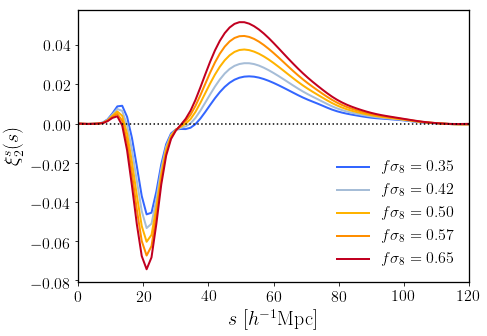

In [4]:
fs8_vals = np.linspace(0.35, 0.65, 5)
theta = np.array([[fs8, 1.14, 380, 1., 1.] for fs8 in fs8_vals])
s = np.linspace(0.01, 120., 81)
mu = np.linspace(0, 1, 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

plt.figure(figsize=(7,5))
for i, th in enumerate(theta):
    
    quadrupole = vgfit.theory_multipoles(th[0], th[1], th[2], th[3], th[4], s, mu)[len(s):]
    plt.plot(s, quadrupole, lw=2, c=colors[i], label=r'$f\sigma_8=%0.2f$' % th[0])
    
plt.tick_params(labelsize=16)
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);

if save_pdf:
    plt.savefig(fig_dir + 'theory_growth_dependence.pdf', bbox_inches='tight')

- Behaviour with $\sigma_v$ (not included in paper)

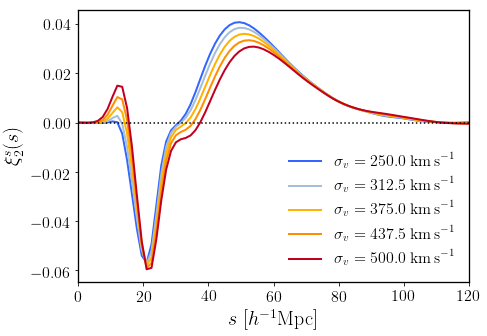

In [5]:
sv_vals = np.linspace(250, 500, 5)
theta = np.array([[0.48, 1.14, sv, 1., 1.] for sv in sv_vals])
s = np.linspace(0.01, 120., 81)
mu = np.linspace(0, 1, 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

plt.figure(figsize=(7,5))
for i, th in enumerate(theta):
    
    quadrupole = vgfit.theory_multipoles(th[0], th[1], th[2], th[3], th[4], s, mu)[len(s):]
    plt.plot(s, quadrupole, lw=2, c=colors[i], label=r'$\sigma_v=%0.1f\;\mathrm{km\,s}^{-1}$' % th[2])
    
plt.tick_params(labelsize=16)
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);

- Behaviour with $\epsilon=\alpha_\perp/\alpha_{||}$ at fixed $\alpha=\alpha_\perp^{2/3}\alpha_{||}^{1/3}=1.0$

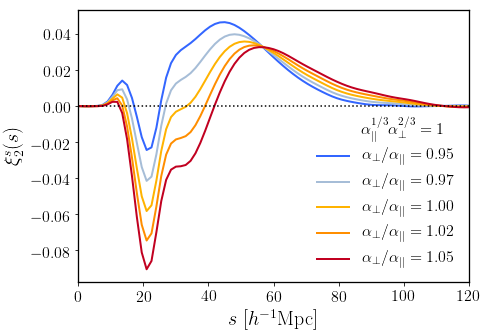

In [6]:
eps_vals = np.linspace(0.95, 1.05, 5)
theta = np.array([[0.48, 1.14, 380, 1., eps] for eps in eps_vals])
s = np.linspace(0.01, 120., 81)
mu = np.linspace(0, 1, 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

plt.figure(figsize=(7,5))
for i, th in enumerate(theta):
    
    apar = th[3] * th[4]**(-2./3)
    aperp = th[4] * apar
    quadrupole = vgfit.theory_multipoles(th[0], th[1], th[2], aperp, apar, s, mu)[len(s):]
    plt.plot(s, quadrupole, lw=2, c=colors[i], label=r'$\alpha_\perp/\alpha_{||}=%0.2f$' % th[4])
    
plt.tick_params(labelsize=16)
# plt.title(r'$\alpha_{||}^{1/3}\alpha_\perp^{2/3}=1$', fontsize=20, y=1.03)
plt.text(87, -0.018, r'$\alpha_{||}^{1/3}\alpha_\perp^{2/3}=1$', fontsize=16);
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);

if save_pdf:
    plt.savefig(fig_dir + 'quadrupole_F_AP_demo.pdf', bbox_inches='tight')

- Behaviour with $\alpha$ at fixed $\alpha_\perp/\alpha_{||}=1$ (with current correct rescaling on the left, and with old incorrect rescaling from first version of the paper on the right)

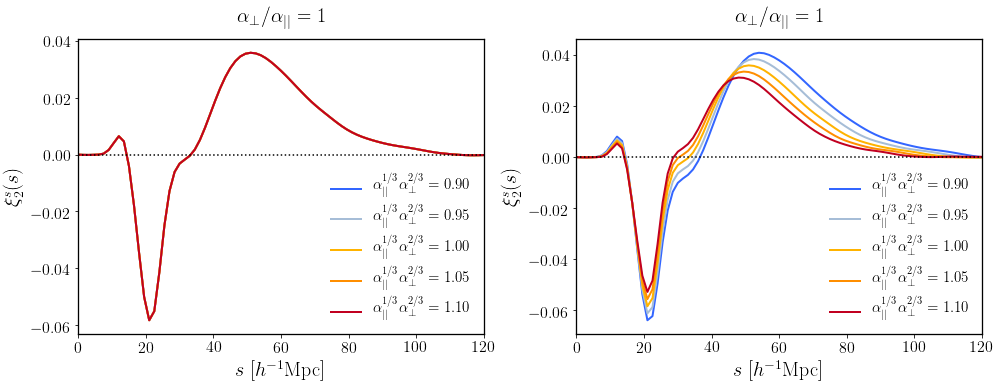

In [7]:
a_vals = np.linspace(0.9, 1.1, 5)
theta = np.array([[0.48, 1.14, 380, a, 1.] for a in a_vals])
s = np.linspace(0.01, 120., 81)
mu = np.linspace(0, 1, 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

figs, axes = plt.subplots(1, 2, figsize=(14, 5.5))
for i, th in enumerate(theta):
    
    apar = th[3] * th[4]**(-2./3)
    aperp = th[4] * apar
    quadrupole = vgfit.theory_multipoles(th[0], th[1], th[2], aperp, apar, s, mu)[len(s):]
    ax = axes.flat[0]
    ax.plot(s, quadrupole, lw=2, c=colors[i], label=r'$\alpha_{||}^{1/3}\alpha_\perp^{2/3}=%0.2f$' % th[3])
    quadrupole = vgfit.theory_multipoles(th[0], th[1], th[2], aperp, apar, s, mu, rescale_all=False)[len(s):]
    ax = axes.flat[1]
    ax.plot(s, quadrupole, lw=2, c=colors[i], label=r'$\alpha_{||}^{1/3}\alpha_\perp^{2/3}=%0.2f$' % th[3])
    
for i in range(2):
    ax = axes.flat[i]
    ax.tick_params(labelsize=16)
    ax.set_title(r'$\alpha_\perp/\alpha_{||}=1$', fontsize=20, y=1.03)
    ax.set_xlim([0, 120])
    ax.axhline(0, c='k', ls=':')
    ax.set_xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
    ax.set_ylabel(r'$\xi^s_2(s)$', fontsize=20)
    ax.legend(loc='lower right', numpoints=1, frameon=False, fontsize=15);
    
plt.tight_layout(w_pad=1)

# Analyse chains

*[Convert the Numpy .npy chain file produced by code to more general FITS format. This allows us to include a header with information on the columns.]*

In [8]:
# chain = np.load('BOSS_DR12_CMASS_data/MCMC_chains/CMASS_Rs10.0_emcee1_SH_mockmono_varycov_r120.0.npy')
# output = np.zeros((chain.shape[0], chain.shape[1] + 3))
# output[:, :chain.shape[1]] = chain
# output[:, chain.shape[1]] = chain[:, 1] / chain[:, 2]
# output[:, chain.shape[1] + 1] = chain[:, 4] * chain[:, 5]**(-2./3)
# output[:, chain.shape[1] + 2] = chain[:, 5] * output[:, chain.shape[1] + 1]

# t = Table(output, names=('logposterior', 'fsigma8', 'bsigma8', 'sigmav', 'alpha', 'epsilon', 'beta', 
#                         'alpha_perp', 'alpha_par'), 
#           meta={'comment': 'logposterior column is the negative of the true log posterior; ' +
#                 'beta, alpha_perp and alpha_par are derived parameters'})
# t.write('BOSS_DR12_CMASS_data/MCMC_chains/CMASS_Rs10.0_emcee1_SH_mockmono_varycov_r120.0.fits', format='fits')

But for current purposes it is just as easy to load the chain as a numpy array object

In [9]:
chain = np.load('BOSS_DR12_CMASS_data/MCMC_chains/CMASS_Rs10.0_emcee1_SH_mockmono_varycov_r120.0.npy')
print("%d samples from posterior" % chain.shape[0])

260000 samples from posterior


### Check trace plots

Text(0.5,0,'Number of steps in each walker')

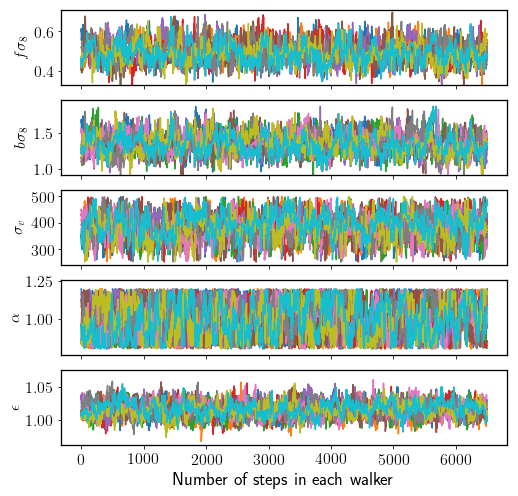

In [10]:
nwalkers = 40

ensemble = chain[:(chain.shape[0] / nwalkers) * nwalkers, :]
ensemble = ensemble.reshape((chain.shape[0] / nwalkers, nwalkers, 6))

labels =  ["$f\sigma_8$", "$b\sigma_8$", "$\sigma_v$", "$\\alpha$", "$\epsilon$"]

fig, axes = plt.subplots(5, 1, figsize=(8,8), sharex=True)
for j in range(5):
    ax = axes.flat[j]
    for i in np.random.randint(nwalkers, size=10):
        ax.plot(ensemble[:, i, j+1])
        ax.set_ylim([0.95 * ensemble[:, i, j+1].min(), 1.05 * ensemble[:, i, j+1].max()])
        if j==4:
            ax.set_ylim([0.98 * ensemble[:, i, j+1].min(), 1.02 * ensemble[:, i, j+1].max()])
        ax.set_ylabel(labels[j], fontsize=16)
        ax.tick_params(labelsize=16)
ax.set_xlabel('Number of steps in each walker', fontsize=18)

### Triangle plot and 1D marginalized results

68% c.l.:
	f\sigma_8 = 0.501\pm 0.051
	b\sigma_8 = 1.37\pm 0.14
	\sigma_v\;[\mathrm{km}/\mathrm{s}] = 387^{+50}_{-40}
	\alpha = ---
	\alpha_\perp/\alpha_{||} = 1.016\pm 0.011
95% c.l.:
	f\sigma_8 = 0.501^{+0.10}_{-0.097}
	b\sigma_8 = 1.37^{+0.27}_{-0.26}
	\sigma_v\;[\mathrm{km}/\mathrm{s}] = 387^{+80}_{-90}
	\alpha = ---
	\alpha_\perp/\alpha_{||} = 1.016^{+0.021}_{-0.021}


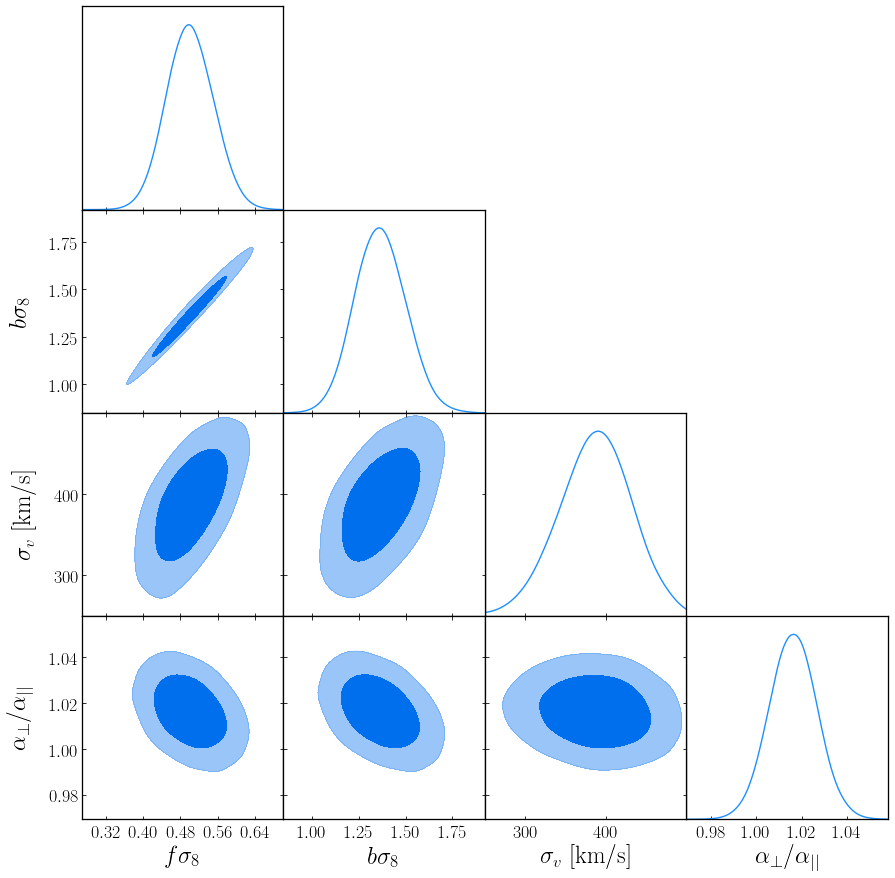

In [11]:
names = ["fs8", "bs8", "sv", "alpha", "epsilon"]
labels =  ["f\sigma_8", "b\sigma_8", "\sigma_v\;[\mathrm{km}/\mathrm{s}]", "\\alpha", 
           "\\alpha_\perp/\\alpha_{||}"]
void_samples = MCSamples(samples=chain[:, 1:], names=names, labels=labels, 
                         ranges={'sv':(250, 500), 'alpha':(0.8, 1.2)}, 
                         settings={'fine_bins_2D': 256, 'smooth_scale_1D': 0.3, 'smooth_scale_2D': 0.4})
p = void_samples.getParams() 
void_samples.addDerived((p.fs8 / p.bs8), name='beta', label='\\beta')
void_samples.addDerived(p.alpha * p.epsilon**(-2./3) , name='apar', label='\\alpha_{||}', range=[0.81, 1.19])
void_samples.addDerived(p.alpha * p.epsilon**(1./3) , name='aperp', label='\\alpha_\perp', range=[0.81, 1.19])

g = plots.getSubplotPlotter(width_inch=12)
g.triangle_plot(void_samples, params=['fs8', 'bs8', 'sv', 'epsilon'], contour_lws=[1.4], filled=True, 
                line_args={'lw':2, 'color':'dodgerblue'}, tight_layout=True)

for i in range(4):
    for ax in g.subplots[i:,i]:
        ax.tick_params(labelsize=18)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24, labelpad=15)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24, labelpad=25)

print('68% c.l.:')
for name in names:
    print('\t' + void_samples.getInlineLatex(name,limit=1))
print('95% c.l.:')
for name in names:
    print('\t' + void_samples.getInlineLatex(name,limit=2))

if save_pdf:
    plt.savefig(fig_dir + 'void_triangle.pdf', bbox_inches='tight')

*(Make a similar plot using corner: this shows the existence of a small second mode at smaller values of $\beta$)*

In [12]:
# import corner
# thin = 1 
# fig = corner.corner(chain[::thin, [1, 2, 3, 5]], 
#                     smooth=1.1, smooth1d=1.1, bins=30,
#                     labels=[r"$f\sigma_8$", 
#                             r"$b\sigma_8$",
#                             r"$\sigma_v$", 
# #                             r"$\alpha_{||}^{1/3}\alpha_{\perp}^{2/3}$",
#                             r"$\alpha_{\perp}/\alpha_{||}$", 
#                            ],
#                     quantiles=[0.16, 0.84],
#                     levels=[0.68, 0.95],
#                     show_titles=True, title_kwargs={"fontsize": 16}, 
#                     label_kwargs={"fontsize": 22})

Confirm that second mode in $\beta$ and to show that it is only a local minimum, not the global one:

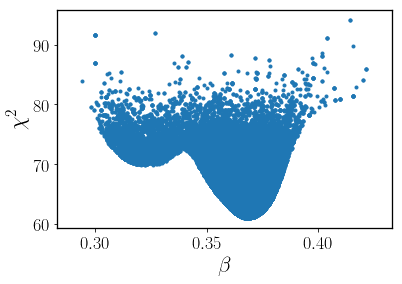

In [13]:
thin = 1
plt.scatter(chain[::thin, 1] / chain[::thin, 2], 999 * (np.exp(2 * chain[::thin, 0]/1000.) - 1), marker='.')
plt.xlabel(r'$\beta$', fontsize=22)
plt.ylabel(r'$\chi^2$', fontsize=22);
plt.tick_params(labelsize=18)

### Maximum-likelihood fit

Minimum chi-squared = 61.014 for (60-4) d.o.f (reduced = 1.090)
[4 parameters are fs8, bs8, sigma_v and epsilon]

Maximum likelihood point, theta = [0.499, 1.36, 390.7 (km/s), 1.016]


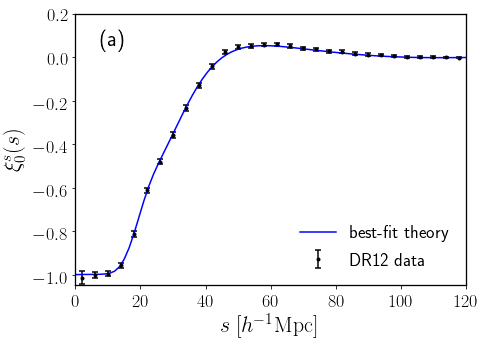

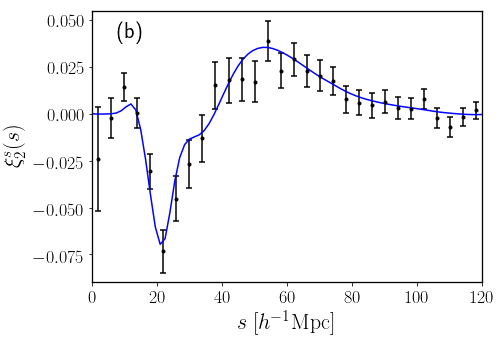

In [14]:
# load the maximum likelihood point
ml_point = np.loadtxt('BOSS_DR12_CMASS_data/maxLikelihood/CMASS_Rs10.0_ML_SH_mockmono_varycov_r120.0.txt')

# get the chi-squared values, remembering log likelihood was calculated using Sellentin & Heavens with Nmocks=1000
chisq = 999 * (np.exp(2 * ml_point[0]/1000.) - 1)
print('Minimum chi-squared = %0.3f for (60-4) d.o.f (reduced = %0.3f)' % (chisq.min(), chisq.min()/56) )
print('[4 parameters are fs8, bs8, sigma_v and epsilon]')

theta = ml_point[:6]
print('\nMaximum likelihood point, theta = [%0.3f, %0.2f, %0.1f (km/s), %0.3f]' % (theta[1], theta[2], 
                                                                                   theta[3], theta[5]))

apar = theta[4] * theta[5]**(-2./3)
aperp = theta[5] * apar
# apar = 1.0 * theta[5]**(-2./3)
# aperp = theta[5] * apar

data_s_multipoles = np.zeros(vgfit.s_multipoles.shape[1])
for i in range(len(data_s_multipoles)):
    interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.s_multipoles[:, i], k=3, ext=2)
    data_s_multipoles[i] = interpolater(theta[1] * vgfit.fiducial_b / theta[2])
covmat = np.zeros((vgfit.covmat.shape[1], vgfit.covmat.shape[2]))
for i in range(vgfit.covmat.shape[1]):
    for j in range(vgfit.covmat.shape[2]):
        interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.covmat[:, i, j], k=3, ext=2)
        covmat[i, j] = interpolater(vgfit.mock_b * theta[1] / theta[2])
errors = np.sqrt(np.diag(covmat))
                        
s = np.linspace(0.01, 120., 81)
mu = np.linspace(0, 1, 81)
theory = vgfit.theory_multipoles(theta[1], theta[2], theta[3], aperp, apar, s, mu)

plt.figure(1, figsize=(7,5))
plt.errorbar(vgfit.r_for_xi, data_s_multipoles[:len(vgfit.r_for_xi)], 
                            yerr=2 * errors[:len(vgfit.r_for_xi)], 
                            c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')
    
plt.plot(s, theory[:len(s)], lw=1.5, label='best-fit theory', c='blue')
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^s_0(s)$", fontsize=22)
plt.text(7.6, 0.05, '(a)', weight='bold', style='italic', fontsize=22)
plt.ylim([-1.05, 0.2])
plt.xlim([0, 120])

if save_pdf:
    plt.savefig(fig_dir + 'CMASS_monopole_Rs10_maxLike.pdf', bbox_inches='tight')
    
plt.figure(2, figsize=(7,5))
plt.errorbar(vgfit.r_for_xi, data_s_multipoles[len(vgfit.r_for_xi):], 
                            yerr=errors[len(vgfit.r_for_xi):], 
                            c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')
    
plt.plot(s, theory[len(s):], lw=1.5, label='best-fit theory', c='blue')
# plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^s_2(s)$", fontsize=22)
plt.text(7.6, 0.04, '(b)', fontweight='bold', style='italic', fontsize=22)
plt.ylim([-0.09, 0.055])
plt.xlim([0, 120])

if save_pdf:
    plt.savefig(fig_dir + 'CMASS_quadrupole_Rs10_maxLike.pdf', bbox_inches='tight')


### Comparison plot for void-only growth rate constraints from CMASS

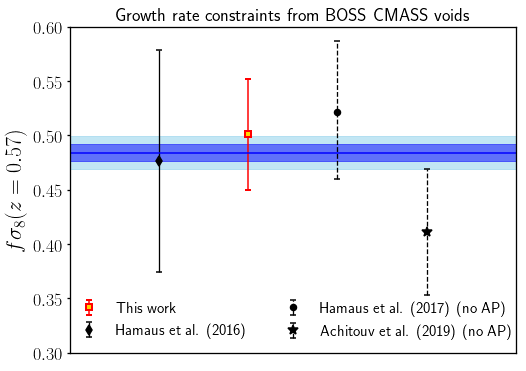

In [15]:
# you would need to change this path to point to Planck MCMC chains on your system
planck2015 = loadMCSamples('/Users/seshadri/software/Planck_LCDM_chains_2018/base_2015/base_plikHM_TTTEEE_lowTEB');

stats = planck2015.getMargeStats()
lims0 = stats.parWithName('fsigma8z057').limits
planck_fs8 = np.zeros((3, 2))
for i, lim0 in enumerate(lims0):
    planck_fs8[i, 0] = lim0.lower
    planck_fs8[i, 1] = lim0.upper
lims0 = stats.parWithName('sigma8z057').limits
planck_s8 = np.zeros((3, 2))
for i, lim0 in enumerate(lims0):
    planck_s8[i, 0] = lim0.lower
    planck_s8[i, 1] = lim0.upper

plt.figure(figsize=(8,6))
x = np.linspace(0, 5)
plt.fill_between(x, np.ones_like(x) * planck_fs8[1, 0], np.ones_like(x) * planck_fs8[1, 1], alpha=0.5, color='skyblue')
plt.fill_between(x, np.ones_like(x) * planck_fs8[0, 0], np.ones_like(x) * planck_fs8[0, 1], alpha=0.5, color='blue')
plt.plot(x, np.ones_like(x) * stats.parWithName('fsigma8z057').mean, color='blue')

s8 = stats.parWithName('sigma8z057').mean
s8err = np.mean([stats.parWithName('sigma8z057').mean - planck_s8[0, 0], 
                 planck_s8[0, 1] - stats.parWithName('sigma8z057').mean])

historical_voids = dict()
historical_voids['labels'] = ['Hamaus et al. (2016)', 'Hamaus et al. (2017) (no AP)', 'Achitouv et al. (2019) (no AP)']
historical_voids['beta'] = np.array([0.417, 0.457, 0.36])
historical_voids['betalower'] = historical_voids['beta'] - np.array([0.089, 0.054, 0.05])
historical_voids['betaupper'] = historical_voids['beta'] + np.array([0.089, 0.056, 0.05])
historical_voids['fs8'] = historical_voids['beta'] * 1.85 * s8
historical_voids['fs8lower'] = historical_voids['fs8'] - \
                               np.sqrt(((historical_voids['beta']-historical_voids['betalower']) * 1.85 * s8)**2 + 
                                       (historical_voids['beta'] * 1.85 * s8err)**2)
historical_voids['fs8upper'] = historical_voids['fs8'] + \
                               np.sqrt(((historical_voids['betaupper']-historical_voids['beta']) * 1.85 * s8)**2 + 
                                       (historical_voids['beta'] * 1.85 * s8err)**2)
historical_voids['x'] = np.array([1, 3, 4])
historical_voids['markers'] = ['d', 'o', '*']
historical_voids['msize'] = [7, 6, 10]

plt.errorbar(2, 0.501, yerr=0.051, fmt='s', markeredgecolor='red', 
             markerfacecolor='gold', c='red', capsize=3,
             markersize=6, elinewidth=1.5, markeredgewidth=2,
             label='This work')

for i in range(len(historical_voids['fs8'])):
    eb = plt.errorbar(historical_voids['x'][i], historical_voids['fs8'][i], 
                 yerr=[[historical_voids['fs8'][i]-historical_voids['fs8lower'][i]],
                       [historical_voids['fs8upper'][i]-historical_voids['fs8'][i]]], 
                 c='k', 
                 fmt=historical_voids['markers'][i],
                 markersize=historical_voids['msize'][i],
                 elinewidth=1.3, markeredgewidth=1.5, 
                 capsize=3,
                 label=historical_voids['labels'][i])
    if i > 0:
        eb[-1][0].set_linestyle('--')

plt.legend(loc='lower center', ncol=2, numpoints=1, frameon=False, fontsize=15)
plt.ylim([0.3, 0.6])
plt.xlim([0., 5])
plt.xticks([])
plt.tick_params(labelsize=18, width=1.3)
plt.ylabel('$f\sigma_8(z=0.57)$', fontsize=22)
plt.title('Growth rate constraints from BOSS CMASS voids', fontsize=18);

if save_pdf:
    plt.savefig(fig_dir + 'void_fs8_vals.pdf', bbox_inches='tight')


In [16]:
# historical_voids['fs8'], historical_voids['fs8'] - historical_voids['fs8lower'], historical_voids['fs8upper'] - historical_voids['fs8']

### Systematics test using Patchy mocks

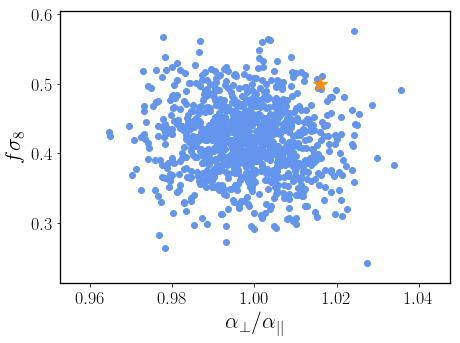

In [18]:
void_ML_vals = np.load('BOSS_DR12_CMASS_data/maxLikelihood/Patchy_CMASS_all_ML_SH_mockmono_varycov_' + 
                       'r120.0_widesvprior.npy')
ml_point = np.loadtxt('BOSS_DR12_CMASS_data/maxLikelihood/CMASS_Rs10.0_ML_SH_mockmono_varycov_r120.0.txt')

plt.figure(figsize=(7,5))
plt.scatter(void_ML_vals[:, 5], void_ML_vals[:, 1], c='cornflowerblue')
plt.plot(ml_point[5], ml_point[1], '*', c='darkorange', markersize=14, markeredgecolor='darkorange')
plt.tick_params(labelsize=18)
plt.xlabel(r"$\alpha_\perp/\alpha_{||}$", fontsize=22)
plt.ylabel(r"$f\sigma_8$", fontsize=22)
if save_pdf:
    plt.savefig(fig_dir + 'systematics_fs8_Fap.pdf', bbox_inches='tight')

### Systematics diagnosis

Fix the real growth rate $f=0.78$ for both DR12 data and Patchy mocks: as the grids were calculated using different fiducial bias values $\left(b_\mathrm{CMASS}=1.85,\;b_\mathrm{Patchy}=2.10\right)$, this corresponds to using different $\beta$ values in the two cases. The data and mocks don't show the same quadrupole in the range  $20<s<40\;h^{−1}$Mpc, which is probably due to some small failure of the approximate ALPT mock generation method.

Plot for f = 0.78


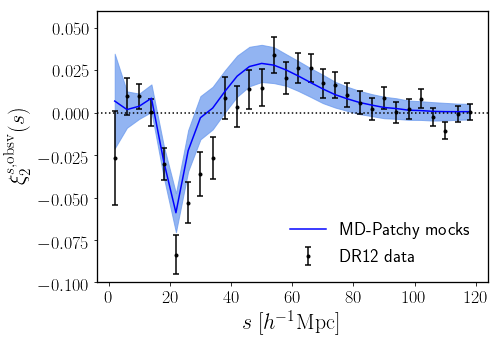

In [19]:
fiducial_f = 0.78
print('Plot for f = %0.2f' % fiducial_f)

data_s_multipoles = np.zeros(vgfit.s_multipoles.shape[1])
for i in range(len(data_s_multipoles)):
    interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.s_multipoles[:, i], k=3, ext=2)
    data_s_multipoles[i] = interpolater(fiducial_f)

patchy_s_multipoles = np.zeros(patchyfit.s_multipoles.shape[1])
for i in range(len(patchy_s_multipoles)):
    interpolater = InterpolatedUnivariateSpline(patchyfit.f_grid, patchyfit.s_multipoles[:, i], k=3, ext=2)
    patchy_s_multipoles[i] = interpolater(fiducial_f)

covmat = np.zeros((vgfit.covmat.shape[1], vgfit.covmat.shape[2]))
for i in range(vgfit.covmat.shape[1]):
    for j in range(vgfit.covmat.shape[2]):
        interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.covmat[:, i, j], k=3, ext=2)
        covmat[i, j] = interpolater(fiducial_f)
errors = np.sqrt(np.diag(covmat))

plt.figure(figsize=(7,5))
plt.errorbar(vgfit.r_for_xi, data_s_multipoles[len(vgfit.r_for_xi):], yerr=errors[len(vgfit.r_for_xi):], 
             c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')
plt.plot(patchyfit.r_for_xi, patchy_s_multipoles[len(patchyfit.r_for_xi):], c='b', label='MD-Patchy mocks')
plt.fill_between(patchyfit.r_for_xi, patchy_s_multipoles[len(patchyfit.r_for_xi):] - errors[len(vgfit.r_for_xi):],
                 patchy_s_multipoles[len(patchyfit.r_for_xi):] + errors[len(vgfit.r_for_xi):], 
                 color='cornflowerblue', alpha=0.7)

plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^{s,\mathrm{obsv}}_2(s)$", fontsize=22)
plt.axhline(0, c='k', ls=':')
plt.ylim([-0.1, 0.06])

if save_pdf:
    plt.savefig(fig_dir + 'fiducial_quadrupole_comparison.pdf', bbox_inches='tight')

Use the same $\beta$ for both DR12 data and Patchy mocks, and keep the fiducial bias values $\left(b_\mathrm{CMASS}=1.85,\;b_\mathrm{Patchy}=2.10\right)$. I think this is a less physical interpretation since it corresponds to using different real growth rates for data and mocks, but in any case it is included to show that even if doing this the data and mocks still don't show the same quadrupole in the range $20<s<40\;h^{-1}$Mpc, which is probably due to some small failure of the approximate ALPT mock generation method.

Plot for f\sigma_8 = 0.499, b\sigma_8 = 1.36, beta = 0.37


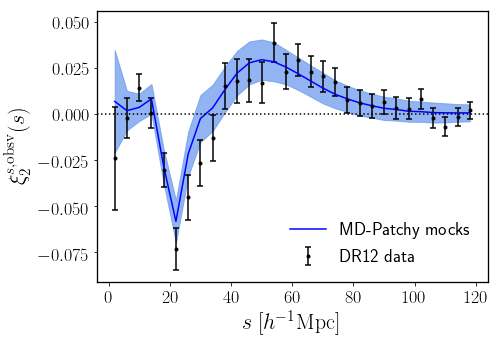

In [20]:
ml_point = np.loadtxt('BOSS_DR12_CMASS_data/maxLikelihood/CMASS_Rs10.0_ML_SH_mockmono_varycov_r120.0.txt')
theta = ml_point[:6]
print('Plot for f\sigma_8 = %0.3f, b\sigma_8 = %0.2f, beta = %0.2f' % (theta[1], theta[2], theta[1] / theta[2]))

data_s_multipoles = np.zeros(vgfit.s_multipoles.shape[1])
for i in range(len(data_s_multipoles)):
    interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.s_multipoles[:, i], k=3, ext=2)
    data_s_multipoles[i] = interpolater(theta[1] * vgfit.fiducial_b / theta[2])

patchy_s_multipoles = np.zeros(patchyfit.s_multipoles.shape[1])
for i in range(len(patchy_s_multipoles)):
    interpolater = InterpolatedUnivariateSpline(patchyfit.f_grid, patchyfit.s_multipoles[:, i], k=3, ext=2)
    patchy_s_multipoles[i] = interpolater(theta[1] * vgfit.mock_b / theta[2])

covmat = np.zeros((vgfit.covmat.shape[1], vgfit.covmat.shape[2]))
for i in range(vgfit.covmat.shape[1]):
    for j in range(vgfit.covmat.shape[2]):
        interpolater = InterpolatedUnivariateSpline(vgfit.f_grid, vgfit.covmat[:, i, j], k=3, ext=2)
        covmat[i, j] = interpolater(vgfit.mock_b * theta[1] / theta[2])
errors = np.sqrt(np.diag(covmat))

plt.figure(figsize=(7,5))
plt.errorbar(vgfit.r_for_xi, data_s_multipoles[len(vgfit.r_for_xi):], yerr=errors[len(vgfit.r_for_xi):], 
             c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')
plt.plot(patchyfit.r_for_xi, patchy_s_multipoles[len(patchyfit.r_for_xi):], c='b', label='MD-Patchy mocks')
plt.fill_between(patchyfit.r_for_xi, patchy_s_multipoles[len(patchyfit.r_for_xi):] - errors[len(vgfit.r_for_xi):],
                 patchy_s_multipoles[len(patchyfit.r_for_xi):] + errors[len(vgfit.r_for_xi):], 
                 color='cornflowerblue', alpha=0.7)

plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^{s,\mathrm{obsv}}_2(s)$", fontsize=22)
plt.axhline(0, c='k', ls=':')

if save_pdf:
    plt.savefig(fig_dir + 'fiducial_quadrupole_comparison_fixbeta.pdf', bbox_inches='tight')

# Cosmological constraints from CMASS

Define fiducial cosmology for the void-galaxy analysis

In [21]:
# fiducial cosmology used for analysis
omega_m_fid = 0.308
h = 0.6736
eff_z = 0.57
H_fid = 100 * h * np.sqrt((omega_m_fid * (1 + eff_z) ** 3 + 1 - omega_m_fid))
Da_fid = cosmo.get_comoving_distance(z=eff_z) / h / (1 + eff_z)

** Galaxy covariance structure**

First we characterize the covariance between post-recon BAO fits and pre-recon full shape fits to the galaxy power spectrum $P(k)$ for CMASS data. We take the 3 parameters for these fits to be $\left(D_A(z)/r_s,\;H(z)r_s,\;f\sigma_8(z)\right)$ at redshift $z=0.57$.

The correlation structure between BAO and RSD results for these parameters is estimated from the maximum likelihood results for BAO and RSD fits to the same set of 2048 Patchy mocks, provided by Hector Gil-Marin. The individual BAO and RSD covariances are taken directly from from Gil-Marin et al (https://arxiv.org/abs/1509.06373) and Gil-Marin et al. (https://arxiv.org/abs/1509.06386) – ***note***: the statistical errors in these papers are different from and generally smaller (more optimistic) than the values inferred from the spread in mock results. 

Headline results for $\left(D_A(z)/r_s,\;H(z)r_s,\;f\sigma_8(z)\right)$ in each case are taken from the papers above.

In [22]:
# --- estimate BAO x RSD cross-covariance --- #
mock_gal_alphas = np.loadtxt('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/data_directory/from Hector/results_cmass.txt')

gal_DaHfs8_matrix = np.empty((2048, 6))

# rows of DaHfs8 matrix will contain: (D_A/r_s)^BAO, (Hr_s)^BAO, (fs8)^BAO=0, (D_A/r_s)^RSD, (Hr_s)^RSD, (fs8)^RSD
gal_DaHfs8_matrix[:, 0] = mock_gal_alphas[1:, 2] * (9.330)              # (D_A/r_s)^BAO = alpha_perp^BAO * fid. val.
gal_DaHfs8_matrix[:, 1] = 1. / mock_gal_alphas[1:, 1] * (13.827 * 1e3)  # (Hr_s)^BAO = fiducial value/alpha_par^BAO
gal_DaHfs8_matrix[:, 2] = 0                                             # fs8 not constrained by BAO
gal_DaHfs8_matrix[:, 3] = mock_gal_alphas[1:, 4] * (1398.43/148.11)     # (D_A/r_s)^RSD = alpha_perp^RSD * fid. val.
gal_DaHfs8_matrix[:, 4] = (92.25 * 148.11) / mock_gal_alphas[1:, 3]     # (Hr_s)^RSD = fiducial value/alpha_par^RSD
gal_DaHfs8_matrix[:, 5] = mock_gal_alphas[1:, 5]                        # fs8

# correlation structure in (D_A/r_s, Hr_s, fs8) basis
gal_DaHfs8_cov = np.cov(gal_DaHfs8_matrix - np.mean(gal_DaHfs8_matrix, axis=0), rowvar=False)
gal_DaHfs8_corr = np.zeros_like(gal_DaHfs8_cov)
diags = np.sqrt(np.diag(gal_DaHfs8_cov))
for i in range(gal_DaHfs8_cov.shape[0]):
    for j in range(gal_DaHfs8_cov.shape[0]):
        if not (diags[i] * diags[j] == 0):
            gal_DaHfs8_corr[i, j] = gal_DaHfs8_cov[i, j] / (diags[i] * diags[j])
                   
# renormalize diagonal errors to match the values from the papers: arXiv:1509.06373 and arXiv:1509.06386
# these are smaller than those inferred from mock results alone!
diags = np.array([0.12, 0.42 * 1e3 , 0, 0.15, 0.44 * 1e3, 0.038])
gal_DaHfs8_cov = np.fromfunction(lambda i,j: gal_DaHfs8_corr[i, j] * (diags[i] * diags[j]), (6, 6), dtype=int)
# ------------------------------------------- #

# post-recon BAO values, taken from 1509.06373
bao_vals = np.array([9.47, 14.67 * 1e3, 0])
bao_x_bao = np.array([[0.12**2, 0.52 * 0.12 * 0.42 * 1e3, 0], [0.52 * 0.12 * 0.42 * 1e3, (0.42 * 1e3)**2, 0],
                      [0, 0, np.inf]])

# pre-recon RSD values, taken from 1509.06386
rsd_vals = np.array([9.42, 13.92 * 1e3, 0.444])
rsd_x_rsd = 1e-3 * np.array([[23.495, 34.180 * 1e3, 3.7495], [34.180 * 1e3, 179.80 * 1e6, 10.597*1e3],
                             [3.7495, 10.597*1e3, 1.3424]])  


# substitute the block diagonal elements
gal_DaHfs8_cov[:3, :3] = bao_x_bao
gal_DaHfs8_cov[3:, 3:] = rsd_x_rsd

### Combined galaxy clustering results from CMASS

Now we combine the BAO and RSD results from these papers assuming Gaussian posteriors and accounting for the correlation determined above to get the 'consensus' galaxy clustering results. This is done using the method of Sanchez et al. (https://arxiv.org/abs/1607.03146)

In [23]:
def combine_posteriors(total_covariance, means, nparams, nexperiments):
    """
    Combine Gaussian posteriors from different experiments, using the BOSS method from Sanchez et al (2016)
    """
    
    psi_joint = np.linalg.inv(total_covariance)
    psi_c = np.zeros((nparams, nparams))
    for i in range(nexperiments):
        for j in range(nexperiments):
            psi_c += psi_joint[nparams*i:(nparams*i) + nparams, nparams*j:nparams*j + nparams]
    consensus_covariance = np.linalg.inv(psi_c)
    
    sum1 = np.zeros(nparams)
    for i in range(nexperiments):
        sum2 = np.zeros((nparams, nparams))
        for j in range(nexperiments):
            sum2 += psi_joint[nparams*j:nparams*j + nparams, nparams*i:nparams*i + nparams]
        sum1 += np.matmul(sum2, means[nparams*i:nparams*i + nparams])
        consensus_means = np.matmul(consensus_covariance, sum1)

    return consensus_means, consensus_covariance
    
galaxy_results, galaxy_covariance = combine_posteriors(gal_DaHfs8_cov, np.hstack([bao_vals, rsd_vals]), 3, 2)

nsample = 1000000
names = ["DArs", "Hrs", "fs8"]
labels =  ["D_A/r_s", "Hr_s\;[\mathrm{km\,s}^{-1}]", "f\sigma_8"]

# BAO posterior
bao_samp = np.random.multivariate_normal(bao_vals[:2], bao_x_bao[:2, :2], size=nsample)
bao_samples = MCSamples(samples=bao_samp, names=names[:2], labels=labels[:2]);
p = bao_samples.getParams() 
bao_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
bao_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
bao_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

# full-shape RSD posterior
rsd_samp = np.random.multivariate_normal(rsd_vals, rsd_x_rsd, size=nsample)
rsd_samples = MCSamples(samples=rsd_samp, names=names, labels=labels);
p = rsd_samples.getParams() 
rsd_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
rsd_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
rsd_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

# combined galaxy clustering posterior
gal_samp = np.random.multivariate_normal(galaxy_results, galaxy_covariance, size=nsample)
galaxy_samples = MCSamples(samples=gal_samp, names=names, labels=labels);
p = galaxy_samples.getParams() 
galaxy_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
galaxy_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
galaxy_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

print('BAO only constraints (68% c.l.):')
for name in ['DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + bao_samples.getInlineLatex(name,limit=1))

print('RSD only constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + rsd_samples.getInlineLatex(name,limit=1))

print('BAO + RSD consensus constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + galaxy_samples.getInlineLatex(name,limit=1))


BAO only constraints (68% c.l.):
	D_A/r_s = 9.47\pm 0.12
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 14.67\pm 0.42
	D_AH/c = 0.463\pm 0.017
	D_v/r_s = 13.71\pm 0.12
RSD only constraints (68% c.l.):
	f\sigma_8 = 0.444\pm 0.037
	D_A/r_s = 9.42\pm 0.15
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 13.92\pm 0.42
	D_AH/c = 0.437\pm 0.018
	D_v/r_s = 13.90\pm 0.14
BAO + RSD consensus constraints (68% c.l.):
	f\sigma_8 = 0.462\pm 0.032
	D_A/r_s = 9.44\pm 0.11
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 14.28\pm 0.34
	D_AH/c = 0.449\pm 0.014
	D_v/r_s = 13.80\pm 0.11


### Cosmological constraints from the CMASS void-galaxy fits

This section just converts the posterior constraints on $\alpha_\perp/\alpha_{||}$ from the void-galaxy measurement into physical quantity $D_AH/c$ using the fiducial cosmology. Note that we add derived parameters $D_A/r_s$ and $Hr_s$ for the void samples only to help with making nice plots below. In fact as void-galaxy measurements do not constrain $\alpha_\perp^{2/3}\alpha_{||}^{1/3}$ the implied closure of the contours for parameters $D_A,\;H$ and $D_v$ is purely due to the (arbitrary) finite range of the prior on $\alpha_\perp^{2/3}\alpha_{||}^{1/3}$. GetDist will give finite error ranges on these quantities from voids alone, but these are not real: we ignore them and set them to be formally infinite when combining posteriors below.

In [24]:
names = ["fs8", "bs8", "sv", "alpha", "epsilon"]
labels =  ["f\sigma_8", "b\sigma_8", "\sigma_v\;[\mathrm{km}/\mathrm{s}]", "\\alpha", 
           "\epsilon=\\alpha_\perp/\\alpha_{||}"]
chain = np.load('BOSS_DR12_CMASS_data/MCMC_chains/CMASS_Rs10.0_emcee1_SH_mockmono_varycov_r120.0.npy')
void_samples = MCSamples(samples=chain[:, 1:], names=names, labels=labels, 
                         ranges={'sv':(250, 500), 'alpha':(0.8, 1.2)}, 
                         settings={'fine_bins_2D': 256, 'smooth_scale_1D': 0.3, 'smooth_scale_2D': 0.5})
vp = void_samples.getParams();
void_samples.addDerived((vp.fs8 / vp.bs8), name='beta', label='\\beta');
void_samples.addDerived(vp.alpha * vp.epsilon**(-2./3) , name='apar', label='\\alpha_{||}', range=[0.81, 1.19]);
void_samples.addDerived(vp.alpha * vp.epsilon**(1./3) , name='aperp', label='\\alpha_\perp', range=[0.81, 1.19]);
vp = void_samples.getParams() 
void_samples.addDerived(H_fid / vp.apar, name='H', label='H\;[\mathrm{km/s/Mpc}]');
void_samples.addDerived(Da_fid * vp.aperp, name='DA', label='D_A\;[\mathrm{Mpc}]');
void_samples.addDerived((H_fid / vp.apar) * 148.11, name='Hrs', label='Hr_s\;[\mathrm{km\,s}^{-1}]');
void_samples.addDerived((Da_fid * vp.aperp) / 148.11, name='DArs', label='D_A/r_s');
vp = void_samples.getParams() 
void_samples.addDerived((H_fid / vp.apar) * 148.11 / 1e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]');
void_samples.addDerived((vp.aperp / vp.apar) * Da_fid * H_fid / 3e5, name='fap', label='D_AH/c');
void_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * vp.DArs)**2 / vp.Hrs)**(1./3), name='Dv', label='D_v/r_s')

print('void-only constraints (68% c.l.):')
for name in ['fs8', 'fap']:
    print('\t' + void_samples.getInlineLatex(name,limit=1))


void-only constraints (68% c.l.):
	f\sigma_8 = 0.501\pm 0.051
	D_AH/c = 0.4367\pm 0.0045


## Combined final CMASS results

We have void-galaxy maximum-likelihood fit results for 1000 of the 2048 Patchy mocks. These need to be compared to the galaxy clustering results in the $\left(D_V/r_s,\;D_AH/c,\;f\sigma_8\right)$ basis (the voids give no constraint on $D_V/r_s$). To do this the strategy is:

- convert BAO/RSD Patchy ML results to $\left(D_V/r_s,\;D_AH/c,\;f\sigma_8\right)$ basis
- build the $9\times9$ joint covariance matrix (for three parameters from 3 methods) from these mock results
- use the BAO and RSD data-based diagonal values to rescale the relevant entries 
- substitute the best estimates of the block diagonal terms (so using mocks only to get the off-diagonal blocks) to obtain the final $9\times9$ covariance matrix
- finally use the Sanchez et al method from above to combine them

In [25]:
void_ML_vals = np.load('BOSS_DR12_CMASS_data/maxLikelihood/Patchy_CMASS_all_ML_SH_mockmono_varycov_' + 
                       'r120.0_widesvprior.npy')
DvFfs8_matrix = np.empty((1000, 9))

DvFfs8_matrix[:, 0] = (3e5 * eff_z * ((1 + eff_z) * gal_DaHfs8_matrix[:1000, 0])**2. 
                           / gal_DaHfs8_matrix[:1000, 1])**(1./3)                        # (D_v/r_s)^BAO
DvFfs8_matrix[:, 1] = gal_DaHfs8_matrix[:1000, 0] * gal_DaHfs8_matrix[:1000, 1] / 3e5    # (D_AH/c)^BAO
DvFfs8_matrix[:, 2] = 0                                                                  # fs8 not constrained by BAO
DvFfs8_matrix[:, 3] = (3e5 * eff_z * ((1 + eff_z) * gal_DaHfs8_matrix[:1000, 3])**2. 
                           / gal_DaHfs8_matrix[:1000, 4])**(1./3)                        # (D_v/r_s)^RSD
DvFfs8_matrix[:, 4] = gal_DaHfs8_matrix[:1000, 3] * gal_DaHfs8_matrix[:1000, 4] / 3e5    # (D_AH/c)^RSD
DvFfs8_matrix[:, 5] = gal_DaHfs8_matrix[:1000, 5]                                        # (fs8)^RSD
DvFfs8_matrix[:, 6] = 0                                                                  # D_v not constrained by voids
DvFfs8_matrix[:, 7] = void_ML_vals[:, 5] * Da_fid * H_fid / 3e5                          # (D_AH/c)^voids
DvFfs8_matrix[:, 8] = void_ML_vals[:, 1]                                                 # (fs8)^voids

# correlation structure in (D_v/r_s, D_AH/c, fs8) basis
DvFfs8_cov = np.cov(DvFfs8_matrix - np.mean(DvFfs8_matrix, axis=0), rowvar=False)
DvFfs8_corr = np.zeros_like(DvFfs8_cov)
diags = np.sqrt(np.diag(DvFfs8_cov))
for i in range(DvFfs8_cov.shape[0]):
    for j in range(DvFfs8_cov.shape[0]):
        if not (diags[i] * diags[j] == 0):
            DvFfs8_corr[i, j] = DvFfs8_cov[i, j] / (diags[i] * diags[j])

# renormalize based on the diagonal errors obtained above
diags = np.hstack([np.sqrt(np.diag(bao_samples.cov(pars=['Dv', 'fap']))), 0, 
                   np.sqrt(np.diag(rsd_samples.cov(pars=['Dv', 'fap', 'fs8']))), 
                   0, np.sqrt(np.diag(void_samples.cov(pars=['fap', 'fs8'])))
                  ])
DvFfs8_cov = np.fromfunction(lambda i,j: DvFfs8_corr[i, j] * (diags[i] * diags[j]), (9, 9), dtype=int)

# now, since this is only an approximate covariance matrix estimated from 1000 mocks, we only want to 
# use it for the off-diagonal blocks – for the diagonal blocks we can do better
DvFfs8_cov[:2, :2] = bao_samples.cov(pars=['Dv', 'fap'])
# BAO doesn't constrain fs8
DvFfs8_cov[2, 2] = np.inf
DvFfs8_cov[3:6, 3:6] = rsd_samples.cov(pars=['Dv', 'fap', 'fs8'])
DvFfs8_cov[7:, 7:] = void_samples.cov(pars=['fap', 'fs8'])
# voids don't constrain Dv
DvFfs8_cov[6, 6] = np.inf  

# set the results vector for each individual method
p = bao_samples.getParams() 
bao_results = np.array([np.median(p.Dv), np.median(p.fap), 0])
p = rsd_samples.getParams() 
rsd_results = np.array([np.median(p.Dv), np.median(p.fap), np.median(p.fs8)])
p = void_samples.getParams() 
void_results = np.array([np.median(p.Dv), np.median(p.fap), np.median(p.fs8)])

# get the consensus results by combining
consensus_results, consensus_covariance = combine_posteriors(DvFfs8_cov, 
                                                             np.hstack([bao_results, rsd_results, void_results]), 
                                                             3, 3)

# create samples from this final posterior for plotting
nsample = 1000000
names = ["Dv", "fap", "fs8"]
labels =  ["D_v/r_s", "D_AH/c", "f\sigma_8"]
samp = np.random.multivariate_normal(consensus_results, consensus_covariance, size=nsample)
consensus_samples = MCSamples(samples=samp, names=names, labels=labels);

# and add other parameters
p = consensus_samples.getParams() 
consensus_samples.addDerived(3e5 * (eff_z * ((1+eff_z)*p.fap)**2)**(1./3) / p.Dv, name='Hrs', 
                             label='Hr_s\;[\mathrm{km\,s}^{-1}]')
consensus_samples.addDerived(3e2 * (eff_z * ((1+eff_z)*p.fap)**2)**(1./3) / p.Dv, name='Hrs1e3', 
                             label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
consensus_samples.addDerived(p.Dv * (p.fap / (eff_z * (1+eff_z)**2))**(1./3), name='DArs', label='D_A/r_s')

print('combined final marged constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + consensus_samples.getInlineLatex(name,limit=1))


combined final marged constraints (68% c.l.):
	f\sigma_8 = 0.453\pm 0.022
	D_A/r_s = 9.384\pm 0.078
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 14.05\pm 0.14
	D_AH/c = 0.4396\pm 0.0040
	D_v/r_s = 13.82\pm 0.11


**Consensus covariance matrix in $\left(D_A/r_s,\;10^{-3}Hr_s,\;f\sigma_8\right)$ basis**:

In [26]:
1e4 * consensus_samples.cov(pars=['DArs', 'Hrs1e3', 'fs8'])

array([[ 60.19990743, -56.32495389,   3.35731206],
       [-56.32495389, 198.70364223,  -2.45934904],
       [  3.35731206,  -2.45934904,   4.94032945]])

**Consensus covariance matrix in $\left(D_v/r_s,\;D_AH/c,\;f\sigma_8\right)$ basis**:

In [27]:
1e4 * consensus_covariance

array([[ 1.15571578e+02, -1.39272519e-01,  4.08629440e+00],
       [-1.39272519e-01,  1.61562048e-01,  8.01756336e-02],
       [ 4.08629440e+00,  8.01756336e-02,  4.93595938e+00]])

## Pretty cosmology plots

For some of these I don't use GetDist just in order to have more control over the aesthetics.

#### A. Constraints in the $(D_A/r_s, Hr_s)$ plane

Note that here the voids constraint is actually only fixing $F_{AP} = D_AH/c$, i.e. it does not depend on the value of $r_s$. Also note that the void contours should in principle not close (as noted above). In practice they do, but well beyond the range shown in the plot (i.e., the prior range on $\alpha_\perp^{2/3}\alpha_{||}^{1/3}$ was plenty broad enough). *[Note we need to increase the number of bins for plotting the void constraints in order to accurately represent the narrowness of the contours!]* 

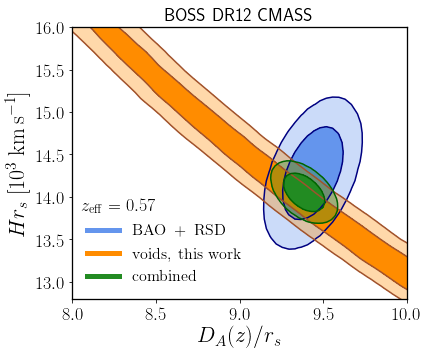

In [28]:
plt.figure(figsize=(6,5))
g = galaxy_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(g.DArs, g.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)
v = void_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(v.DArs, v.Hrs1e3, bins=80)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='darkorange', color2='sienna')
c = consensus_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(c.DArs, c.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='forestgreen', color2='darkgreen')

plt.plot(0.6, 0.7, c='cornflowerblue', lw=5, label='$\mathrm{BAO\;+\;RSD}$')
plt.plot(0.6, 0.7, c='darkorange', lw=5, label='$\mathrm{voids,\;this\;work}$')
plt.plot(0.6, 0.7, c='forestgreen', lw=5, label='$\mathrm{combined}$')

plt.xlim([8., 10.])
plt.ylim([12.8, 16.0])
plt.xlabel(r'$D_A(z)/r_s$', fontsize=22)
plt.ylabel(r'$Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]$', fontsize=22)
plt.tick_params(labelsize=18)
plt.legend(loc='lower left', frameon=False, fontsize=16)
plt.title('BOSS DR12 CMASS', fontsize=18);
plt.text(8.05, 13.8, '$z_\mathrm{eff}=0.57$', fontsize=18);

if save_pdf:
    plt.savefig(fig_dir + 'Da-H-plot.pdf', bbox_inches='tight')


**Minor unresolved question**: In the plot above, why does the green contour appear shifted slightly upwards from the intersection of blue and orange? Have I made a mistake somewhere or is this consistent?

#### B. Constraints in the $\left(D_AH/c, f\sigma_8\right)$ plane

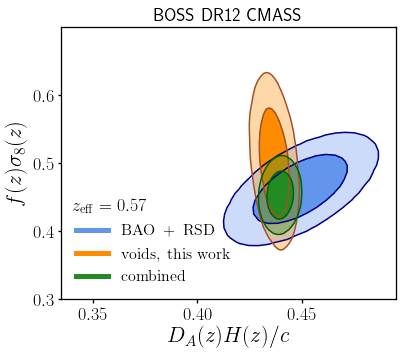

In [29]:
plt.figure(figsize=(6,5))
g = galaxy_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(g.fap, g.fs8, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)
v = void_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(v.fap, v.fs8, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='darkorange', color2='sienna')
c = consensus_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(c.fap, c.fs8, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='forestgreen', color2='darkgreen')

plt.plot(0.6, 0.7, c='cornflowerblue', lw=5, label='$\mathrm{BAO\;+\;RSD}$')
plt.plot(0.6, 0.7, c='darkorange', lw=5, label='$\mathrm{voids,\;this\;work}$')
plt.plot(0.6, 0.7, c='forestgreen', lw=5, label='$\mathrm{combined}$')
plt.ylim([0.3, 0.7])
plt.xlim([0.335, 0.495])
plt.yticks([0.3, 0.4, 0.5, 0.6])
plt.tick_params(labelsize=18, width=1.3)
plt.xlabel('$D_A(z)H(z)/c$', fontsize=22)
plt.ylabel('$f(z)\sigma_8(z)$', fontsize=22)
plt.legend(loc='lower left', frameon=False, fontsize=16)
plt.title('BOSS DR12 CMASS', fontsize=18);
plt.text(0.34, 0.425, '$z_\mathrm{eff}=0.57$', fontsize=18);

if save_pdf:
    plt.savefig(fig_dir + 'fs8-F_AP-plot-Da.pdf', bbox_inches='tight')


#### C. Alternative version of previous plot, without labels

In [30]:
# plt.figure(figsize=(6,5))
# g = galaxy_samples.getParams() 
# X2, Y2, H2, V, Hmax, levels = fu.contour_2d(g.fap, g.fs8, bins=30)
# fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)
# v = void_samples.getParams() 
# X2, Y2, H2, V, Hmax, levels = fu.contour_2d(v.fap, v.fs8, bins=30)
# fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='darkorange', color2='sienna')
# c = consensus_samples.getParams() 
# X2, Y2, H2, V, Hmax, levels = fu.contour_2d(c.fap, c.fs8, bins=30)
# fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='forestgreen', color2='darkgreen')
# plt.plot(galaxy_results[0] * galaxy_results[1] / 3e5, galaxy_results[2], '*', markersize=10)
# plt.plot(void_results[1], void_results[2], '*', markersize=10)
# plt.plot(consensus_results[1], consensus_results[2], '*', markersize=10)

# plt.ylim([0.3, 0.65])
# plt.xlim([0.4, 0.495])
# # plt.yticks([0.3, 0.4, 0.5, 0.6])
# plt.tick_params(labelsize=18, width=1.3)
# plt.xlabel('$D_A(z)H(z)/c$', fontsize=22)
# plt.ylabel('$f(z)\sigma_8(z)$', fontsize=22)
# plt.title('BOSS DR12 CMASS', fontsize=18);
# # plt.text(0.34, 0.425, '$z_\mathrm{eff}=0.57$', fontsize=18);


#### D. $(D_A/r_s, Hr_s)$ constraints compared to Planck 2015 base $\Lambda$CDM (TTTEEE + lowTEB)

Note the relevance of the previous unresolved question ... the consensus contours seem marginally high compared to Planck 2015.

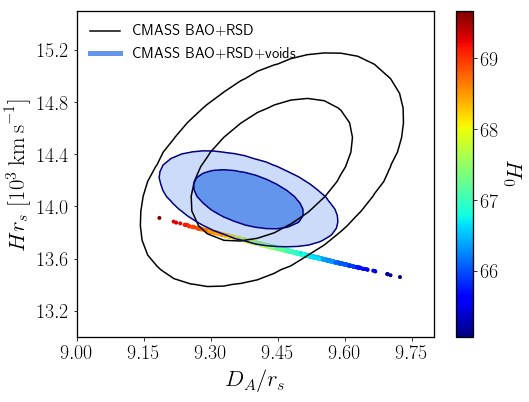

In [31]:
# you would need to change this path to point to Planck MCMC chains on your system
planck2015 = loadMCSamples('/Users/seshadri/software/Planck_LCDM_chains_2018/base_2015/base_plikHM_TTTEEE_lowTEB');

gplot = plots.getSinglePlotter(width_inch=8)
p = planck2015.getParams()
planck2015.addDerived(p.DA057 / p.rdrag, name='DArs', label='D_A/r_s')
planck2015.addDerived(p.Hubble057 * p.rdrag / 1e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
gplot.plot_3d(planck2015, ['DArs', 'Hrs1e3', 'H0'])

# gplot.plot_2d([galaxy_samples, consensus_samples], ['DArs', 'Hrs1e3'], filled=[False, True])
g = galaxy_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(g.DArs, g.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='none', color2='k')
c = consensus_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(c.DArs, c.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)

plt.plot(0.6, 0.7, c='k', label='CMASS BAO+RSD')
plt.plot(0.6, 0.7, c='cornflowerblue', lw=5, label='CMASS BAO+RSD+voids')

plt.xlim([9.0, 9.8])
plt.ylim([13, 15.5])
plt.legend(loc='upper left', frameon=False, fontsize=15)

if save_pdf:
    plt.savefig(fig_dir + 'Da-H-Planck-plot.pdf', bbox_inches='tight')


Confirm that it is the post-recon BAO result that pulls the combined result high, as voids and RSD both overlap Planck and each other at $1\sigma$: 

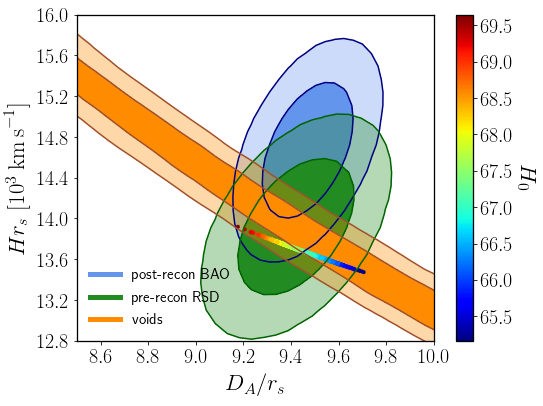

In [32]:
planck2015 = loadMCSamples('/Users/seshadri/software/Planck_LCDM_chains_2018/base_2015/base_plikHM_TTTEEE_lowTEB');

gplot = plots.getSinglePlotter(width_inch=8)
p = planck2015.getParams()
planck2015.addDerived(p.DA057 / p.rdrag, name='DArs', label='D_A/r_s')
planck2015.addDerived(p.Hubble057 * p.rdrag / 1e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')

b = bao_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(b.DArs, b.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)

r = rsd_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(r.DArs, r.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='forestgreen', color2='darkgreen')

v = void_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(v.DArs, v.Hrs1e3, bins=80)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='darkorange', color2='sienna')
gplot.plot_3d(planck2015, ['DArs', 'Hrs1e3', 'H0'])

plt.plot(0.6, 0.7, c='cornflowerblue', lw=5, label='post-recon BAO')
plt.plot(0.6, 0.7, c='forestgreen', lw=5, label='pre-recon RSD')
plt.plot(0.6, 0.7, c='darkorange', lw=5, label='voids')

plt.xlim([8.5, 10.0])
# plt.ylim([13, 15.5])
plt.ylim([12.8, 16.0])
plt.legend(loc='lower left', frameon=False, fontsize=15)

plt.savefig(fig_dir + 'where_is_the_discrepancy.pdf', bbox_inches='tight')

Alternative version, which includes the combined RSD + voids contours

void_plus_rsd marged constraints (68% c.l.):
	f\sigma_8 = 0.454\pm 0.022
	D_A/r_s = 9.443\pm 0.099
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 13.93\pm 0.17
	D_AH/c = 0.4386\pm 0.0041
	D_v/r_s = 13.92\pm 0.14


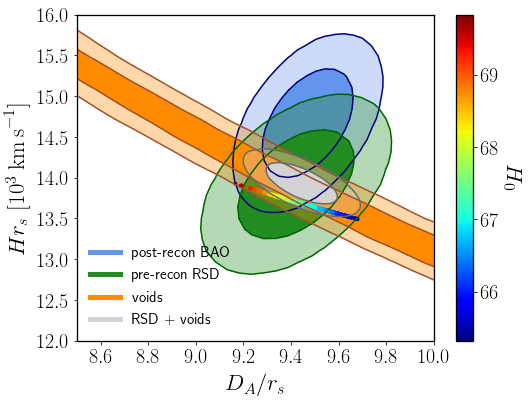

In [33]:
# get the consensus results by combining
void_plus_rsd_results, void_plus_rsd_covariance = combine_posteriors(DvFfs8_cov[3:, 3:], 
                                                                     np.hstack([rsd_results, void_results]), 
                                                                     3, 2)

# create samples from this final posterior for plotting
nsample = 1000000
names = ["Dv", "fap", "fs8"]
labels =  ["D_v/r_s", "D_AH/c", "f\sigma_8"]
samp = np.random.multivariate_normal(void_plus_rsd_results, void_plus_rsd_covariance, size=nsample)
void_plus_rsd_samples = MCSamples(samples=samp, names=names, labels=labels);

# and add other parameters
p = void_plus_rsd_samples.getParams() 
void_plus_rsd_samples.addDerived(3e5 * (eff_z * ((1+eff_z)*p.fap)**2)**(1./3) / p.Dv, name='Hrs', 
                                 label='Hr_s\;[\mathrm{km\,s}^{-1}]')
void_plus_rsd_samples.addDerived(3e2 * (eff_z * ((1+eff_z)*p.fap)**2)**(1./3) / p.Dv, name='Hrs1e3', 
                                 label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
void_plus_rsd_samples.addDerived(p.Dv * (p.fap / (eff_z * (1+eff_z)**2))**(1./3), name='DArs', label='D_A/r_s')

print('void_plus_rsd marged constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + void_plus_rsd_samples.getInlineLatex(name,limit=1))

    planck2015 = loadMCSamples('/Users/seshadri/software/Planck_LCDM_chains_2018/base_2015/base_plikHM_TTTEEE_lowTEB');

gplot = plots.getSinglePlotter(width_inch=8)
p = planck2015.getParams()
planck2015.addDerived(p.DA057 / p.rdrag, name='DArs', label='D_A/r_s')
planck2015.addDerived(p.Hubble057 * p.rdrag / 1e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')

b = bao_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(b.DArs, b.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels)

r = rsd_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(r.DArs, r.Hrs1e3, bins=30)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='forestgreen', color2='darkgreen')

v = void_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(v.DArs, v.Hrs1e3, bins=80)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='darkorange', color2='sienna')

j = void_plus_rsd_samples.getParams() 
X2, Y2, H2, V, Hmax, levels = fu.contour_2d(j.DArs, j.Hrs1e3, bins=80)
fu.plot_contour_2d(X2, Y2, H2, V, Hmax, levels, color1='lightgrey', color2='dimgrey')

gplot.plot_3d(planck2015, ['DArs', 'Hrs1e3', 'H0'])

plt.plot(0.6, 0.7, c='cornflowerblue', lw=5, label='post-recon BAO')
plt.plot(0.6, 0.7, c='forestgreen', lw=5, label='pre-recon RSD')
plt.plot(0.6, 0.7, c='darkorange', lw=5, label='voids')
plt.plot(0.6, 0.7, c='lightgrey', lw=5, label='RSD + voids')

plt.xlim([8.5, 10.0])
# plt.ylim([13, 15.5])
plt.ylim([12., 16.0])
plt.legend(loc='lower left', frameon=False, fontsize=15)


#### E. Comparison plot of different  $f\sigma_8$ measurements

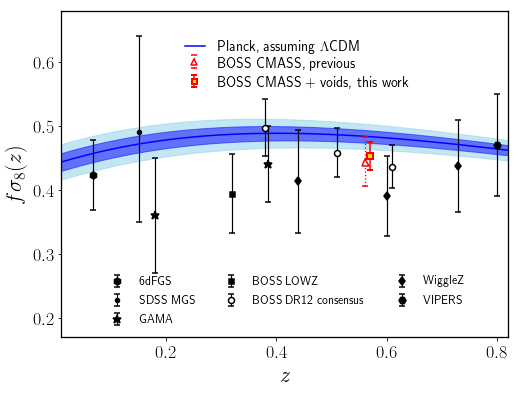

In [34]:
from scipy.special import hyp2f1

def fs8_of_z(z, s80=0.811, om_m = 0.308, gamma=0.55):
    
    Ez = np.sqrt((om_m * (1 + z) ** 3 + 1 - om_m))
    az = 1. / (1 + z)
    omega_l = 1. - om_m
    growth = az ** 2.5 * np.sqrt(omega_l + om_m * az ** (-3.)) * \
                  hyp2f1(5. / 6, 3. / 2, 11. / 6, -(omega_l * az ** 3.) / om_m) / \
                  hyp2f1(5. / 6, 3. / 2, 11. / 6, -omega_l / om_m)
    f = ((om_m * (1 + z)**3.) / (om_m * (1 + z)**3 + omega_l))**gamma
    
    return f * s80 * growth

def s8_of_z(z, s80=0.811, om_m = 0.308, gamma=0.55):
    
    az = 1. / (1 + z)
    omega_l = 1. - om_m
    growth = az ** 2.5 * np.sqrt(omega_l + om_m * az ** (-3.)) * \
                  hyp2f1(5. / 6, 3. / 2, 11. / 6, -(omega_l * az ** 3.) / om_m) / \
                  hyp2f1(5. / 6, 3. / 2, 11. / 6, -omega_l / om_m)
    
    return s80 * growth

plt.figure(figsize=(8,6))

zvals = np.linspace(0.0, 0.85)
om = 0.3156; omerr = 0.0091
s8 = 0.8311; s8err = 0.013
fs8vals = fs8_of_z(zvals, om_m=om, s80=s8)
plt.plot(zvals, fs8vals, c='blue', lw=1.5)
s = 2
fs8low = fs8_of_z(zvals, om_m=om-s*omerr, s80=s8-s*s8err)
fs8high = fs8_of_z(zvals, om_m=om+s*omerr, s80=s8+s*s8err)
plt.fill_between(zvals, fs8low, fs8high, alpha=0.5, color='skyblue')
s = 1
fs8low = fs8_of_z(zvals, om_m=om-s*omerr, s80=s8-s*s8err)
fs8high = fs8_of_z(zvals, om_m=om+s*omerr, s80=s8+s*s8err)
plt.fill_between(zvals, fs8low, fs8high, alpha=0.5, color='blue')

fs8data = dict()
fs8data['labels'] = ['6dFGS', 'SDSS MGS', 'GAMA', 'BOSS LOWZ', 'BOSS DR12 consensus', None, 
                     'WiggleZ', None, 'BOSS CMASS', None, None, None, 'VVDS', 'VIPERS']
fs8data['redshifts'] = [0.067,  # 6dFGS: Beutler et al 2012, arXiv:1204.4725  
                        0.15,  # SDSS MGS: Howlett et al 2015, arXiv:1409.3238
                        0.18,  # GAMA: Blake et al 2013, arXiv:1309.5556
                        0.32,  # BOSS LOWZ: Gil-Marin et al 2016, arXiv:1509.06386
                        0.38,  # BOSS DR12 consensus: Alam et al 2016, arXiv:1607.03155
                        0.38 + 0.005,  # GAMA, slightly shifted for clarity
                        0.44,  # WiggleZ: Blake et al 2012, arXiv:1204.3674
                        0.51,  # BOSS DR12 consensus
                        0.57,  # BOSS CMASS: Gil-Marin et al 2016, arXiv:1509.06386
                        0.6,   # WiggleZ
                        0.61,  # BOSS DR12 consensus
                        0.73,  # WiggleZ
                        0.77,  # VVDS: Guzzo et al 2008
                        0.80   # VIPERS: de la Torre et al 2013, arXiv:1303.2622
                       ]
fs8data['fs8'] = [0.423,  # 6dFGS: Beutler et al 2012,  
                  0.49,   # SDSS MGS: Howlett et al 2015 
                  0.36,   # GAMA: Blake et al 2013
                  0.394,  # BOSS LOWZ: Gil-Marin et al 2016, arXiv:1509.06386
                  0.497,  # BOSS DR12 consensus: Alam et al 2016, arXiv:1607.03155
                  0.44,   # GAMA
                  0.413,  # WiggleZ: Blake et al 2012
                  0.458,  # BOSS DR12 consensus
                  0.444,  # BOSS CMASS: Gil-Marin et al 2016, arXiv:1509.06386
                  0.390,  # WiggleZ
                  0.436,  # BOSS DR12 consensus
                  0.437,  # WiggleZ
                  0.90 * 0.55,  # VVDS: Guzzo et al 2008
                  0.47    # VIPERS
                 ]
fs8data['errors'] = [0.055,  # 6dFGS: Beutler et al 2012,  
                     [[0.14], [0.15]],  # SDSS MGS: Howlett et al 2015 
                     0.09,  # GAMA: Blake et al 2013
                     0.062,  # BOSS LOWZ: Gil-Marin et al 2016, arXiv:1509.06386
                     0.045,  # BOSS DR12 consensus: Alam et al 2016, arXiv:1607.03155
                     0.06,  # GAMA
                     0.08,  # WiggleZ: Blake et al 2012
                     0.038,  # BOSS DR12 consensus
                     0.038,  # BOSS CMASS: Gil-Marin et al 2016, arXiv:1509.06386
                     0.063,   # WiggleZ
                     0.034,  # BOSS DR12 consensus
                     0.072,  # WiggleZ
                     0.36 * 0.55,  # VVDS: Guzzo et al 2008
                     0.08    # VIPERS
                 ]
fs8data['markers'] = ['h', '.', '*', 's', 'o', '*', 'd', 'o', 's', 'd', 'o', 'd', 'H', 'H']
fs8data['msize'] = [7, 8, 9, 5, 6, 9, 6, 6, 7, 6, 6, 6, 7, 7]
fs8data['mfcolors'] = ['k', 'k', 'k', 'k', 'white', 'k', 'k', 'white', 'k', 'k', 'white', 'k', 'k', 'k']
fs8data['toplot'] = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13]
    
for i in fs8data['toplot']:
    plt.errorbar(fs8data['redshifts'][i], fs8data['fs8'][i], 
                 yerr=fs8data['errors'][i], 
                 c='k', markerfacecolor=fs8data['mfcolors'][i], 
                 fmt=fs8data['markers'][i],
                 markersize=fs8data['msize'][i],
                 elinewidth=1.2, markeredgewidth=1.5, 
                 label=fs8data['labels'][i], capsize=3
                )

plt.legend(loc='lower center', ncol=3, numpoints=1, frameon=False, fontsize=12)

outlinecolor = 'red'
eb = plt.errorbar(0.57-0.01, 0.444, yerr=0.038, fmt='^', markeredgecolor=outlinecolor, 
                  markerfacecolor='white', c=outlinecolor, elinewidth=1.3, 
                  markersize=7, markeredgewidth=1.5, capsize=3)
eb[-1][0].set_linestyle(':')
plt.errorbar(0.57, 0.453, yerr=0.022, fmt='s', markeredgecolor=outlinecolor, 
             markerfacecolor='gold', c=outlinecolor, 
             markersize=6, elinewidth=1.5, markeredgewidth=2,
             capsize=3)

# this is an ugly hack because it seems impossible to put two legends in one figure
x = np.linspace(0.235,0.27)
plt.plot(x, 0.625 * np.ones_like(x), c='blue', lw=1.5, label=r'Planck, assuming $\Lambda$CDM')
eb = plt.errorbar(0.25, 0.6, yerr=0.01, fmt='^', markeredgecolor=outlinecolor, 
                  markerfacecolor='white', c=outlinecolor, elinewidth=1.2, 
                  markersize=6, markeredgewidth=1.5, capsize=3)
eb[-1][0].set_linestyle(':')
plt.errorbar(0.25, 0.57, yerr=0.01, fmt='s', markeredgecolor=outlinecolor, 
             markerfacecolor='gold', c=outlinecolor, 
             markersize=5, elinewidth=1.5, markeredgewidth=2,
             capsize=3)
plt.text(0.295, 0.617, r'Planck, assuming $\Lambda$CDM', fontsize=14);
plt.text(0.295, 0.59, r'BOSS CMASS, previous', fontsize=14);
plt.text(0.295, 0.56, r'BOSS CMASS + voids, this work', fontsize=14);


plt.xlim([0.01, 0.82])
plt.ylim([0.17, 0.68])
plt.tick_params(labelsize=18)
plt.ylabel('$f\sigma_8(z)$', fontsize=22)
plt.xlabel('$z$', fontsize=22)

if save_pdf:
    plt.savefig(fig_dir + 'fs8_values.pdf', bbox_inches='tight')


# Cosmological constraints from LOWZ (no voids)

** Galaxy covariance structure**

First we characterize the covariance between post-recon BAO fits and pre-recon full shape fits to the galaxy power spectrum $P(k)$ for LOWZ data. We take the 3 parameters for these fits to be $\left(D_A(z)/r_s,\;H(z)r_s,\;f\sigma_8(z)\right)$ at redshift $z=0.32$.

The correlation structure between BAO and RSD results for these parameters is estimated from the maximum likelihood results for BAO and RSD fits to the same set of 2048 Patchy mocks, provided by Hector Gil-Marin. The individual BAO and RSD covariances are taken directly from from Gil-Marin et al (https://arxiv.org/abs/1509.06373) and Gil-Marin et al. (https://arxiv.org/abs/1509.06386) – ***note***: the statistical errors in these papers are different from and generally smaller (more optimistic) than the values inferred from the spread in mock results. 

Headline results for $\left(D_A(z)/r_s,\;H(z)r_s,\;f\sigma_8(z)\right)$ in each case are taken from the papers above.

In [35]:
# --- estimate BAO x RSD cross-covariance --- #
mock_gal_alphas = np.loadtxt('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/data_directory/from Hector/results_lowz.txt')

gal_DaHfs8_matrix = np.empty((2048, 6))

# rows of DaHfs8 matrix will contain: (D_A/r_s)^BAO, (Hr_s)^BAO, (fs8)^BAO=0, (D_A/r_s)^RSD, (Hr_s)^RSD, (fs8)^RSD
gal_DaHfs8_matrix[:, 0] = mock_gal_alphas[1:, 2] * (6.667)              # (D_A/r_s)^BAO = alpha_perp^BAO * fid. val.
gal_DaHfs8_matrix[:, 1] = 1. / mock_gal_alphas[1:, 1] * (11.914 * 1e3)  # (Hr_s)^BAO = fiducial value/alpha_par^BAO
gal_DaHfs8_matrix[:, 2] = 0                                             # fs8 not constrained by BAO
gal_DaHfs8_matrix[:, 3] = mock_gal_alphas[1:, 4] * (999.23/148.11)      # (D_A/r_s)^RSD = alpha_perp^RSD * fid. val.
gal_DaHfs8_matrix[:, 4] = (79.49 * 148.11) / mock_gal_alphas[1:, 3]     # (Hr_s)^RSD = fiducial value/alpha_par^RSD
gal_DaHfs8_matrix[:, 5] = mock_gal_alphas[1:, 5]                        # fs8

# correlation structure in (D_A/r_s, Hr_s, fs8) basis
gal_DaHfs8_cov = np.cov(gal_DaHfs8_matrix - np.mean(gal_DaHfs8_matrix, axis=0), rowvar=False)
gal_DaHfs8_corr = np.zeros_like(gal_DaHfs8_cov)
diags = np.sqrt(np.diag(gal_DaHfs8_cov))
for i in range(gal_DaHfs8_cov.shape[0]):
    for j in range(gal_DaHfs8_cov.shape[0]):
        if not (diags[i] * diags[j] == 0):
            gal_DaHfs8_corr[i, j] = gal_DaHfs8_cov[i, j] / (diags[i] * diags[j])
                   
# renormalize diagonal errors to match the values from the papers: arXiv:1509.06373 and arXiv:1509.06386
# these are smaller than those inferred from mock results alone!
diags = np.array([0.15, 0.69 * 1e3 , 0, 0.19, 0.56 * 1e3, 0.062])
gal_DaHfs8_cov = np.fromfunction(lambda i,j: gal_DaHfs8_corr[i, j] * (diags[i] * diags[j]), (6, 6), dtype=int)
# ------------------------------------------- #

# post-recon BAO values, taken from 1509.06373
bao_vals = np.array([6.67, 11.63 * 1e3, 0])
bao_x_bao = np.array([[0.15**2, 0.35 * 0.15 * 0.69 * 1e3, 0], [0.35 * 0.15 * 0.69 * 1e3, (0.69 * 1e3)**2, 0],
                      [0, 0, np.inf]])

# pre-recon RSD values, taken from 1509.06386
rsd_vals = np.array([6.35, 11.41 * 1e3, 0.394])
rsd_x_rsd = 1e-3 * np.array([[34.912, 51.366 * 1e3, 7.4600], [51.366 * 1e3, 310.08 * 1e6, 25.549*1e3],
                             [7.4600, 25.549*1e3, 4.1028]])  


# substitute the block diagonal elements
gal_DaHfs8_cov[:3, :3] = bao_x_bao
gal_DaHfs8_cov[3:, 3:] = rsd_x_rsd

### Combined galaxy clustering results from LOWZ

Now we combine the BAO and RSD results from these papers assuming Gaussian posteriors and accounting for the correlation determined above to get the 'consensus' galaxy clustering results. This is done using the method of Sanchez et al. (https://arxiv.org/abs/1607.03146)

In [36]:
galaxy_results, galaxy_covariance = combine_posteriors(gal_DaHfs8_cov, np.hstack([bao_vals, rsd_vals]), 3, 2)

nsample = 1000000
names = ["DArs", "Hrs", "fs8"]
labels =  ["D_A/r_s", "Hr_s\;[\mathrm{km\,s}^{-1}]", "f\sigma_8"]

# BAO posterior
bao_samp = np.random.multivariate_normal(bao_vals[:2], bao_x_bao[:2, :2], size=nsample)
bao_samples = MCSamples(samples=bao_samp, names=names[:2], labels=labels[:2]);
p = bao_samples.getParams() 
bao_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
bao_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
bao_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

# full-shape RSD posterior
rsd_samp = np.random.multivariate_normal(rsd_vals, rsd_x_rsd, size=nsample)
rsd_samples = MCSamples(samples=rsd_samp, names=names, labels=labels);
p = rsd_samples.getParams() 
rsd_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
rsd_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
rsd_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

# combined galaxy clustering posterior
gal_samp = np.random.multivariate_normal(galaxy_results, galaxy_covariance, size=nsample)
galaxy_samples = MCSamples(samples=gal_samp, names=names, labels=labels);
p = galaxy_samples.getParams() 
galaxy_samples.addDerived(p.Hrs / 1.e3, name='Hrs1e3', label='Hr_s\;[10^3\;\mathrm{km\,s}^{-1}]')
galaxy_samples.addDerived(p.DArs * p.Hrs / 3.e5, name='fap', label='D_AH/c')
galaxy_samples.addDerived((3e5 * eff_z * ((1 + eff_z) * p.DArs)**2 / p.Hrs)**(1./3), name='Dv', label='D_v/r_s')

print('BAO only constraints (68% c.l.):')
for name in ['DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + bao_samples.getInlineLatex(name,limit=1))

print('RSD only constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + rsd_samples.getInlineLatex(name,limit=1))

print('BAO + RSD consensus constraints (68% c.l.):')
for name in ['fs8', 'DArs', 'Hrs1e3', 'fap', 'Dv']:
    print('\t' + galaxy_samples.getInlineLatex(name,limit=1))

print(r'BAO + RSD consensus covariance $10^3C_{ij}$:')
rescaled_gal_covariance = np.copy(galaxy_covariance)
rescaled_gal_covariance[:, 1] /= 1e3
rescaled_gal_covariance[1, :] /= 1e3
print(1e3 * rescaled_gal_covariance)


BAO only constraints (68% c.l.):
	D_A/r_s = 6.67\pm 0.15
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 11.63\pm 0.69
	D_AH/c = 0.259\pm 0.018
	D_v/r_s = 11.73\pm 0.24
RSD only constraints (68% c.l.):
	f\sigma_8 = 0.394\pm 0.064
	D_A/r_s = 6.35\pm 0.19
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 11.41\pm 0.56
	D_AH/c = 0.242\pm 0.016
	D_v/r_s = 11.42\pm 0.21
BAO + RSD consensus constraints (68% c.l.):
	f\sigma_8 = 0.427\pm 0.055
	D_A/r_s = 6.55\pm 0.13
	Hr_s\;[10^3\;\mathrm{km\,s}^{-1}] = 11.57\pm 0.47
	D_AH/c = 0.253\pm 0.013
	D_v/r_s = 11.61\pm 0.16
BAO + RSD consensus covariance $10^3C_{ij}$:
[[ 15.68448142  28.30091089   3.63193346]
 [ 28.30091089 221.88649611  16.38064319]
 [  3.63193346  16.38064319   2.99465001]]


# Cosmological model fits (from CosmoMC chains)

Here we compare the model constraints from fitting to Planck 2015 TT, TE, EE and low-$\ell$ data, plus either the official BOSS DR12 consensus results, or our new LOWZ + CMASS + voids values using the means and covariance matrices above). Obviously these chains need to exist somewhere on your system before you can run the following cells; change the paths appropriately.

Load the chains and print summary stats

In [37]:
lcdm_old = loadMCSamples('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/cosmomc_chains/LCDM_Planck_BOSSconsensus', 
                          settings={'ignore_rows': 0.0, 'fine_bins': 2048}
                        )
lcdm_new = loadMCSamples('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/cosmomc_chains/LCDM_Planck_' + 
                         'BOSSnewDR12CMASSLOWZvoids', 
                         settings={'ignore_rows': 0.0, 'fine_bins': 2048}
                        )
owcdm_old = loadMCSamples('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/cosmomc_chains/owCDM_Planck_BOSSconsensus', 
                          settings={'ignore_rows': 0.0, 'fine_bins': 2048}
                         )
owcdm_new = loadMCSamples('/Users/seshadri/Workspace/BOSS_DR12_voidRSD/cosmomc_chains/owCDM_Planck_' + 
                          'BOSSnewDR12CMASSLOWZvoids', 
                          settings={'ignore_rows': 0.0, 'fine_bins': 2048}
                         )
print('LCDM model:\n\tBOSS consensus:')
for name in ['omegam', 'H0']:
    print('\t\t' + lcdm_old.getInlineLatex(name,limit=1) + ' (68%);\n\t\t' + 
          lcdm_old.getInlineLatex(name,limit=2) + ' (95%)')
print('\tLOWZ + CMASS + voids:')
for name in ['omegam', 'H0']:
    print('\t\t' + lcdm_new.getInlineLatex(name,limit=1) + ' (68%);\n\t\t' + 
          lcdm_new.getInlineLatex(name,limit=2) + ' (95%)')

print('owCDM model:\n\tBOSS consensus:')
for name in ['omegak', 'H0', 'w', 'omegam']:
    print('\t\t' + owcdm_old.getInlineLatex(name,limit=1) + ' (68%);\n\t\t' + 
          owcdm_old.getInlineLatex(name,limit=2) + ' (95%)')
print('\tLOWZ + CMASS + voids :')
for name in ['omegak', 'H0', 'w', 'omegam']:
    print('\t\t' + owcdm_new.getInlineLatex(name,limit=1) + ' (68%);\n\t\t' + 
          owcdm_new.getInlineLatex(name,limit=2) + ' (95%)')
 

LCDM model:
	BOSS consensus:
		\Omega_m = 0.3105\pm 0.0064 (68%);
		\Omega_m = 0.310^{+0.013}_{-0.012} (95%)
		H_0 = 67.62\pm 0.48 (68%);
		H_0 = 67.62^{+0.94}_{-0.94} (95%)
	LOWZ + CMASS + voids:
		\Omega_m = 0.3093\pm 0.0057 (68%);
		\Omega_m = 0.309^{+0.011}_{-0.011} (95%)
		H_0 = 67.71\pm 0.43 (68%);
		H_0 = 67.71^{+0.83}_{-0.84} (95%)
owCDM model:
	BOSS consensus:
		\Omega_K = 0.0012^{+0.0025}_{-0.0033} (68%);
		\Omega_K = 0.0012^{+0.0066}_{-0.0054} (95%)
		H_0 = 67.9\pm 1.3 (68%);
		H_0 = 67.9^{+2.6}_{-2.5} (95%)
		w = -0.999\pm 0.068 (68%);
		w = -0.999^{+0.13}_{-0.14} (95%)
		\Omega_m = 0.310\pm 0.012 (68%);
		\Omega_m = 0.310^{+0.025}_{-0.024} (95%)
	LOWZ + CMASS + voids :
		\Omega_K = 0.0015^{+0.0022}_{-0.0026} (68%);
		\Omega_K = 0.0015^{+0.0053}_{-0.0045} (95%)
		H_0 = 67.67\pm 0.90 (68%);
		H_0 = 67.7^{+1.8}_{-1.7} (95%)
		w = -0.983\pm 0.047 (68%);
		w = -0.983^{+0.092}_{-0.093} (95%)
		\Omega_m = 0.3107\pm 0.0086 (68%);
		\Omega_m = 0.311^{+0.017}_{-0.016} (95%)


Percentage improvement in $\Omega_M$ and $H_0$ uncertainties in $\Lambda$CDM 

In [38]:
print('%0.3f per cent improvement for Omega_m' % ((0.0064-0.0057) / 0.0064))
print('%0.3f per cent improvement for H_0' % ((0.48-0.43) / 0.48))

0.109 per cent improvement for Omega_m
0.104 per cent improvement for H_0


Calculate percentage improvement in "Figure of Merit" or allowed volume of parameter space (covering all cosmologically relevant parameters)

In [39]:
def fom(covmat):
    return 1.0 / np.sqrt(np.linalg.det(covmat))

def vol(covmat):
    return np.sqrt(np.linalg.det(covmat))

six_par_list = ['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns']
eight_par_list = ['omegabh2', 'omegach2', 'theta', 'tau', 'omegak', 'w', 'logA', 'ns']

print('FOM % improvement from void data:')
print('\tin LCDM: %0.2f' % (100 * (fom(lcdm_new.cov(pars=six_par_list)) - 
                                   fom(lcdm_old.cov(pars=six_par_list))) / fom(lcdm_old.cov(pars=six_par_list))))
print('\tin owCDM: %0.2f' % (100 * (fom(owcdm_new.cov(pars=eight_par_list)) - 
                                    fom(owcdm_old.cov(pars=eight_par_list))) / fom(owcdm_old.cov(pars=eight_par_list))))

print('parameter space volume % reduction from void data:')
print('\tin LCDM: %0.2f' % (100 * (vol(lcdm_old.cov(pars=six_par_list)) - 
                                   vol(lcdm_new.cov(pars=six_par_list))) / vol(lcdm_old.cov(pars=six_par_list))))
print('\tin owCDM: %0.2f' % (100 * (vol(owcdm_old.cov(pars=eight_par_list)) - 
                                    vol(owcdm_new.cov(pars=eight_par_list))) / vol(owcdm_old.cov(pars=eight_par_list))))


FOM % improvement from void data:
	in LCDM: 12.43
	in owCDM: 87.57
parameter space volume % reduction from void data:
	in LCDM: 11.06
	in owCDM: 46.69


#### 2D contour plots for $ow$CDM model

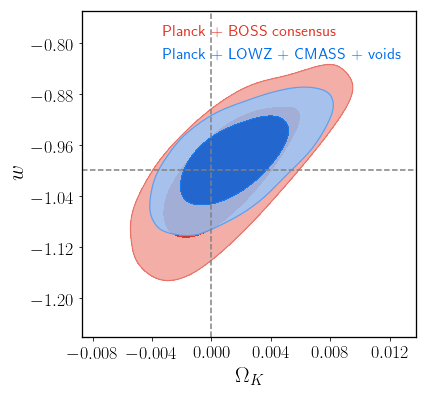

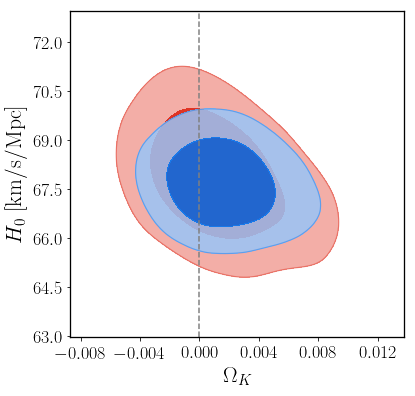

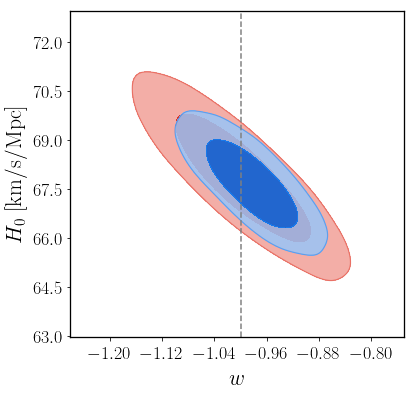

In [40]:
gplot = plots.getSinglePlotter(width_inch=6, ratio=1)
gplot.plot_2d([owcdm_old, owcdm_new], 'omegak', 'w', filled=True)
plt.xlabel(r'$\Omega_K$', fontsize=22)
plt.ylabel(r'$w$', fontsize=22)
plt.tick_params(labelsize=18)
plt.axvline(0, c='grey', ls='--')
plt.axhline(-1, c='grey', ls='--')
gplot.add_legend(['Planck + BOSS consensus', 'Planck + LOWZ + CMASS + voids'], colored_text=True);
if save_pdf:
    plt.savefig(fig_dir + 'w_OmegaK_constraints.pdf', bbox_inches='tight')

gplot = plots.getSinglePlotter(width_inch=6, ratio=1)
gplot.plot_2d([owcdm_old, owcdm_new], 'omegak', 'H0', filled=True)
plt.xlabel(r'$\Omega_K$', fontsize=22)
plt.ylabel(r'$H_0\;[\mathrm{km/s/Mpc}]$', fontsize=22)
plt.tick_params(labelsize=18)
plt.axvline(0, c='grey', ls='--')
if save_pdf:
    plt.savefig(fig_dir + 'H0_OmegaK_constraints.pdf', bbox_inches='tight')

gplot = plots.getSinglePlotter(width_inch=6, ratio=1)
gplot.plot_2d([owcdm_old, owcdm_new], 'w', 'H0', filled=True)
plt.xlabel(r'$w$', fontsize=22)
plt.ylabel(r'$H_0\;[\mathrm{km/s/Mpc}]$', fontsize=22)
plt.tick_params(labelsize=18)
plt.axvline(-1, c='grey', ls='--')
if save_pdf:
    plt.savefig(fig_dir + 'H0_w_constraints.pdf', bbox_inches='tight')
